LOAD DATA

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from textblob import TextBlob
import numpy as np

# Load the dataset
file_path = 'avatar.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Set the plot style
sns.set(style="whitegrid")


IMDB RATINGS ANALYSIS

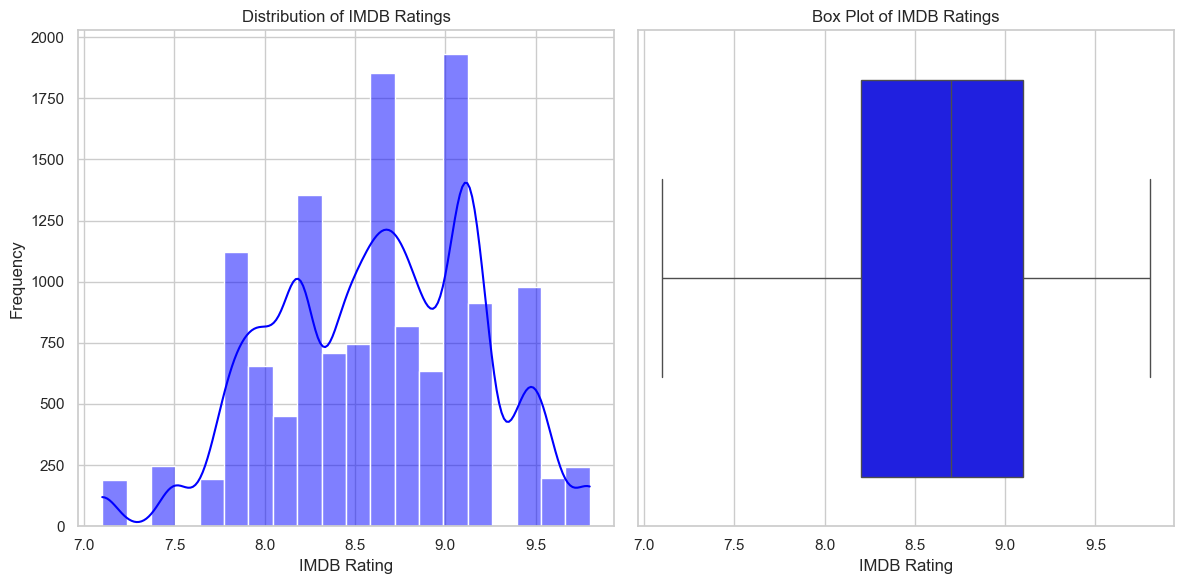

In [48]:
# 1. Distribution of IMDB Ratings
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data['imdb_rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=data['imdb_rating'], color='blue')
plt.title('Box Plot of IMDB Ratings')
plt.xlabel('IMDB Rating')

plt.tight_layout()
plt.show()

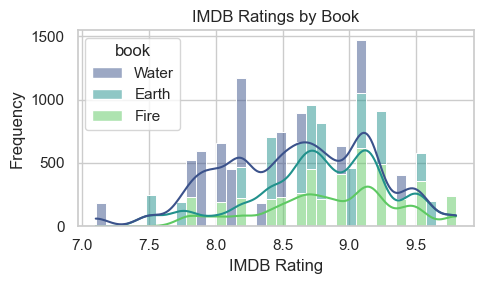

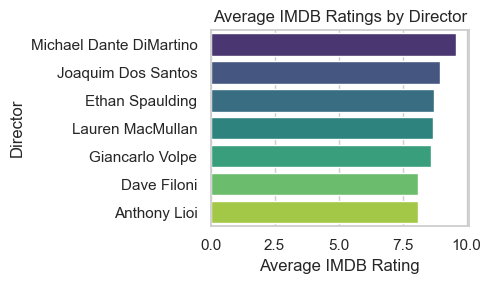

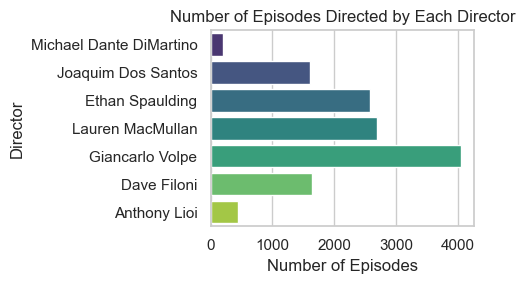

In [49]:
# Set the plot style
sns.set(style="whitegrid")

# 2. IMDB Ratings by Book
plt.figure(figsize=(5, 3))
sns.histplot(data, x='imdb_rating', hue='book', multiple='stack', palette='viridis', kde=True)
plt.title('IMDB Ratings by Book')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. IMDB Ratings by Director
director_ratings = data.groupby('director')['imdb_rating'].agg(['mean', 'count']).reset_index()
director_ratings = director_ratings.sort_values(by='mean', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(x='mean', y='director', data=director_ratings, palette='viridis', orient='h')
plt.title('Average IMDB Ratings by Director')
plt.xlabel('Average IMDB Rating')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(x='count', y='director', data=director_ratings, palette='viridis', orient='h')
plt.title('Number of Episodes Directed by Each Director')
plt.xlabel('Number of Episodes')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

import plotly.express as px

chapter_ratings = data.groupby('chapter')['imdb_rating'].mean().reset_index()


fig = px.bar(chapter_ratings, x='chapter', y='imdb_rating', 
             labels={'chapter': 'Chapter', 'imdb_rating': 'Average IMDB Rating'},
             title='Average IMDB Rating per Chapter',
             hover_data={'chapter': True})

fig.update_layout(xaxis_title='Chapter', yaxis_title='Average IMDB Rating', 
                  xaxis_tickangle=90)

# Show the plot
fig.show()


WORD CLOUDS AND SENTIMENT ANALYSIS

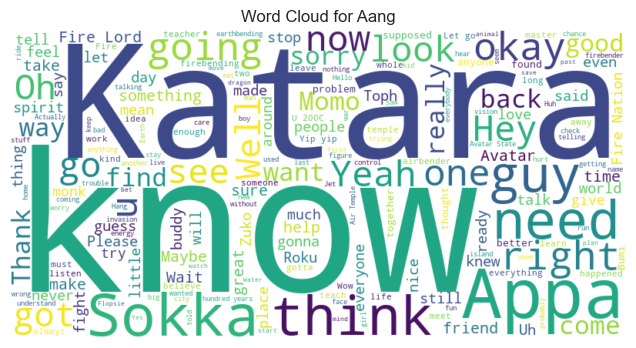

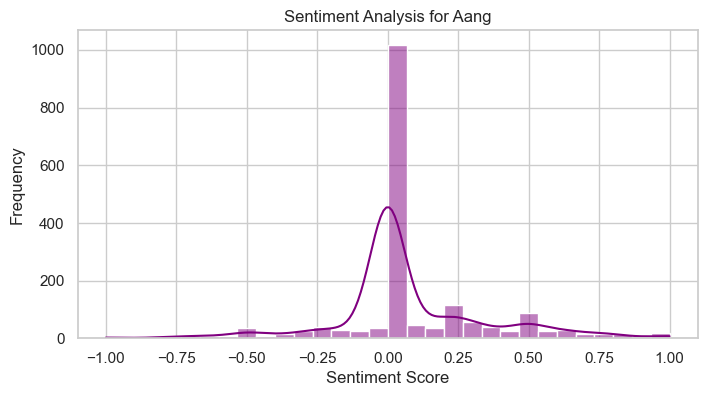

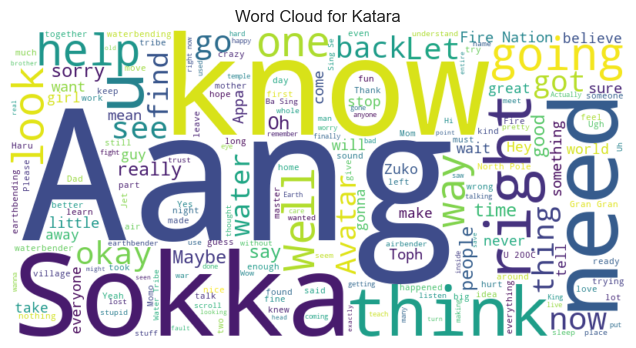

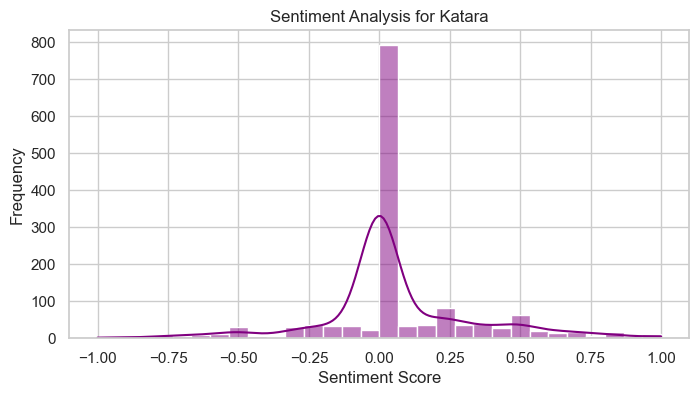

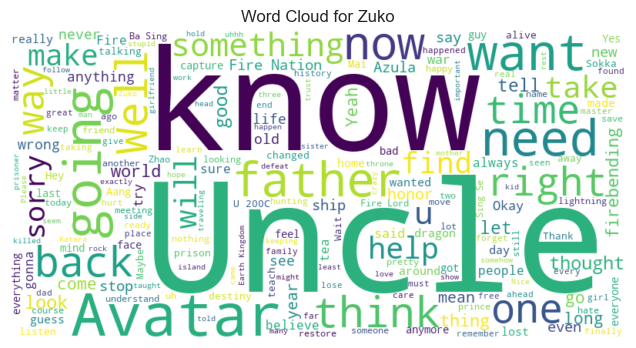

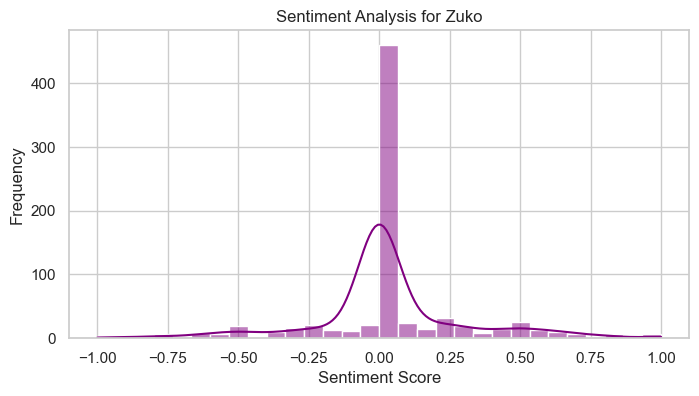

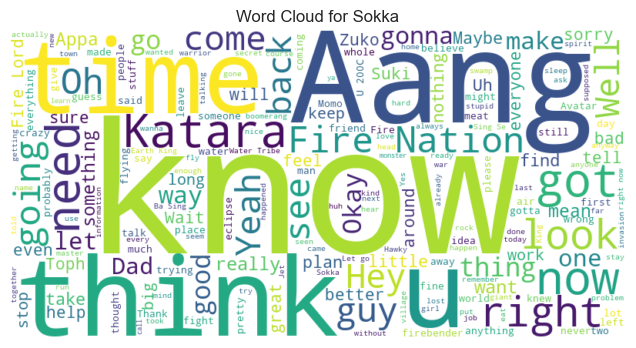

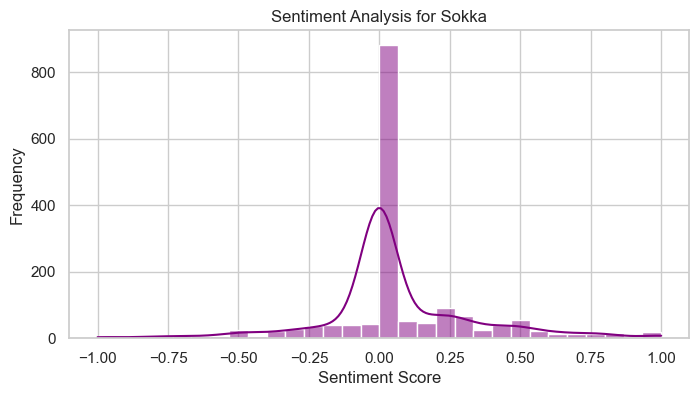

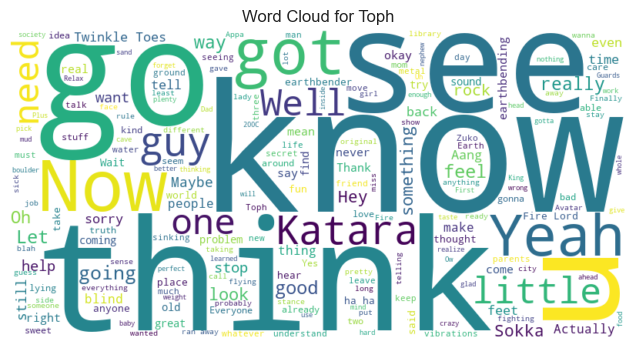

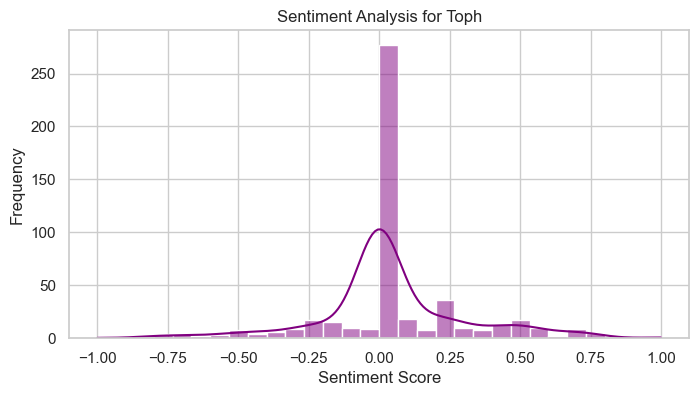

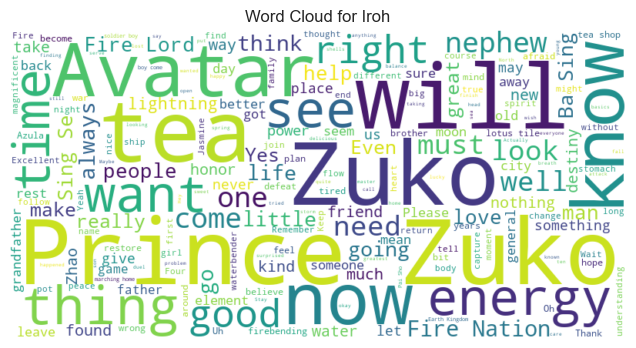

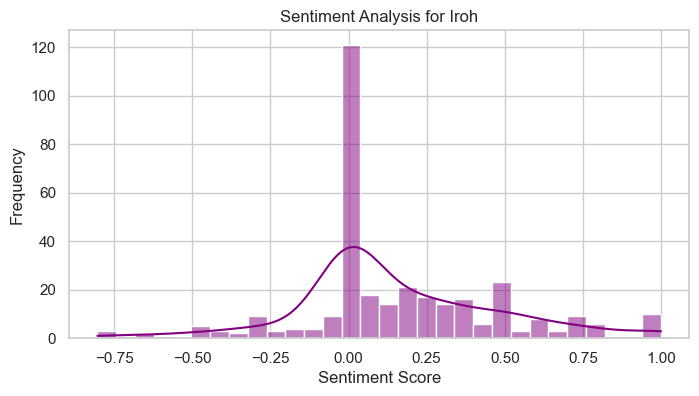

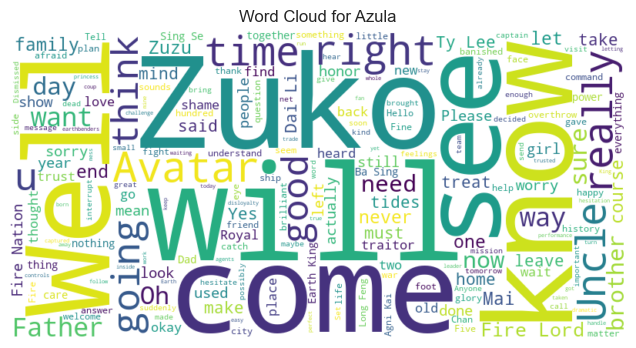

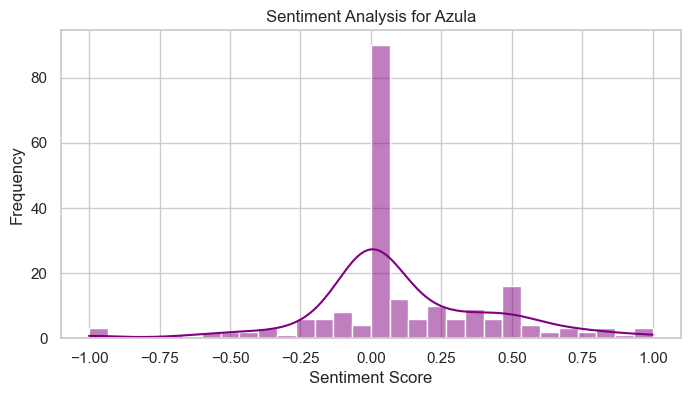

In [50]:


characters = ['Aang', 'Katara', 'Zuko', 'Sokka', 'Toph', 'Iroh', 'Azula']

for character in characters:
    character_data = data[data['character'] == character]
    
    if not character_data['character_words'].dropna().empty:
        # Generate word cloud
        character_text = ' '.join(character_data['character_words'].dropna().astype(str).tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(character_text)
        
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {character}')
        plt.show()
        
   
        character_data['sentiment'] = character_data['character_words'].dropna().apply(lambda x: TextBlob(x).sentiment.polarity)

        plt.figure(figsize=(8, 4))
        sns.histplot(character_data['sentiment'], bins=30, kde=True, color='purple')
        plt.title(f'Sentiment Analysis for {character}')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.show()


LINE ANALYSIS

In [51]:
# Number of lines per chapter
chapter_lines = data['chapter'].value_counts().reset_index()
chapter_lines.columns = ['chapter', 'line_count']

fig_lines = px.bar(chapter_lines, x='chapter', y='line_count', 
                   labels={'chapter': 'Chapter', 'line_count': 'Number of Lines'},
                   title='Number of Lines per Chapter',
                   hover_data={'chapter': True})

fig_lines.update_layout(xaxis_title='Chapter', yaxis_title='Number of Lines', 
                        xaxis_tickangle=90)

fig_lines.show()


CHARACTER INTERACTION

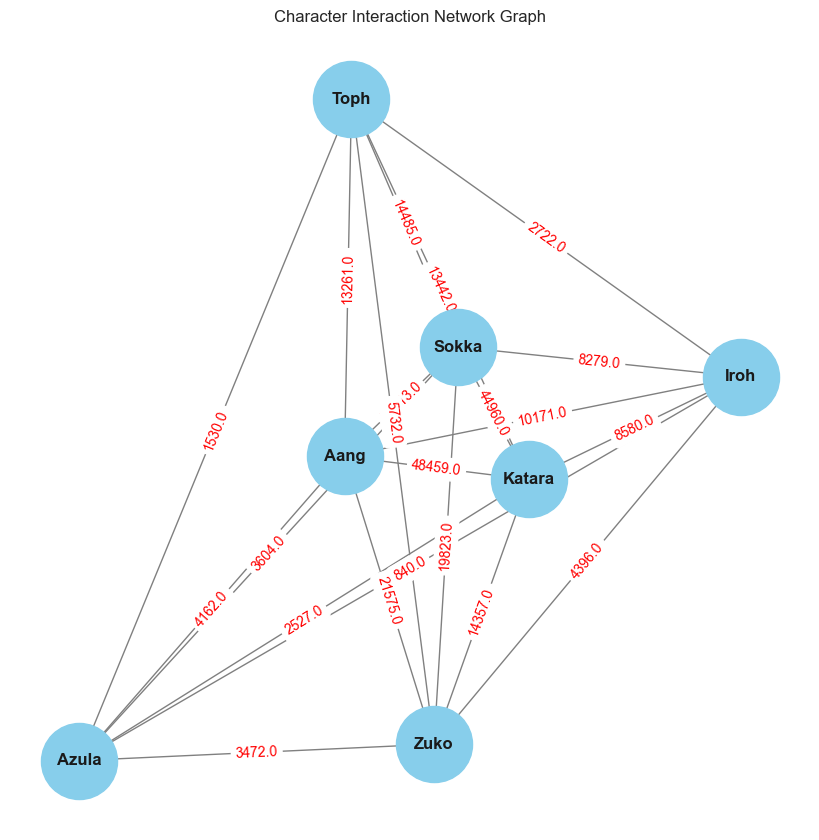

In [52]:

filtered_data = data[data['character'].isin(characters)]

#co-occurrence matrix
co_occurrence = pd.crosstab(filtered_data['chapter'], filtered_data['character'])

interaction_matrix = co_occurrence.T.dot(co_occurrence)
interaction_matrix = interaction_matrix.where(~np.eye(interaction_matrix.shape[0], dtype=bool))

# interaction graph
G = nx.Graph()

for character in characters:
    G.add_node(character)

for i, character1 in enumerate(characters):
    for j, character2 in enumerate(characters):
        if i < j and interaction_matrix.loc[character1, character2] > 0:
            G.add_edge(character1, character2, weight=interaction_matrix.loc[character1, character2])


plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='grey', font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}, font_color='red')
plt.title('Character Interaction Network Graph')
plt.show()


---------------------------------------------
---------------------------------CHAPTER CLUSTERING--------------------------------
-------------------------------------------------------------------------
------------------------------------



In [53]:
import pandas as pd
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import warnings
import tensorflow as tf


# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Suppress all warnings
warnings.filterwarnings("ignore")

Corpus Oluşturma ve Öznitelik Seçme 

In [54]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.decomposition import PCA
import tensorflow_hub as hub

nltk.download('stopwords')

# İngilizce stopwords listesini al
stop_words = set(stopwords.words('english'))

# ChapterCorpus veri çerçevesi 
chapterCorpus = pd.DataFrame({'Chapter Name': [], 'Full Text': [], 'Book': []})
chapters = []
chapterTexts = []
books = []
for book in ['Water', 'Earth', 'Fire']:
    subBook = data[data['book'] == book] 
    for chapter_name, df in subBook.groupby('chapter'):
        # Karakter sözlerini birleştir ve küçük harfe dönüştür
        full_text = df['character_words'].fillna("").astype(str).values
        full_text_combined = " ".join(full_text).lower()
        
        # Stopwords'leri filtrele
        filtered_text = " ".join([word for word in full_text_combined.split() if word not in stop_words])
        
        chapters.append(chapter_name)
        chapterTexts.append(filtered_text)
        books.append(book)

chapterCorpus['Chapter Name'] = chapters
chapterCorpus['Full Text'] = chapterTexts
chapterCorpus['Book'] = books

# Universal Sentence Encoder 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
features = model(chapterCorpus['Full Text'].values)

pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features)

chapterCorpus['Dimension 1'] = reduced_features[:,0]
chapterCorpus['Dimension 2'] = reduced_features[:,1]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozgeo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cluster Sayısını Seçme

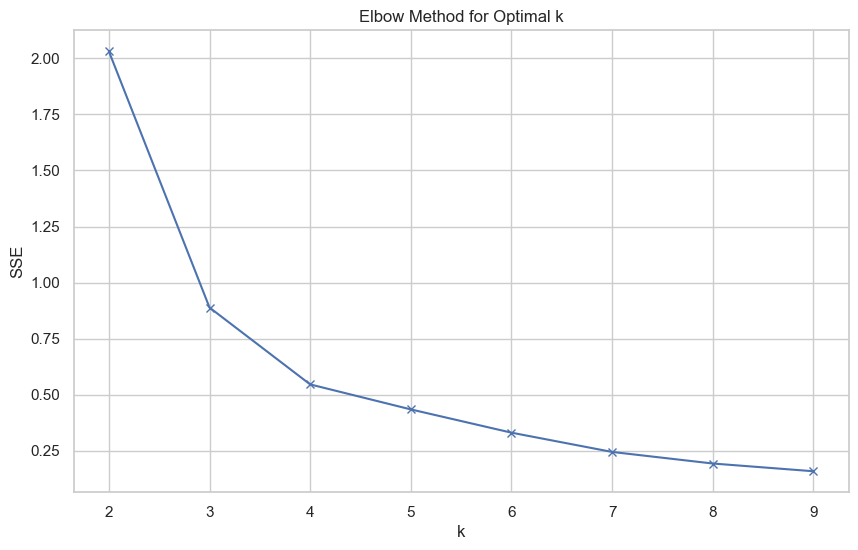

In [55]:
# Elbow Yöntemi
def plot_elbow_method(reduced_features):
    distortions = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(reduced_features)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method for Optimal k')
    plt.show()

plot_elbow_method(reduced_features)

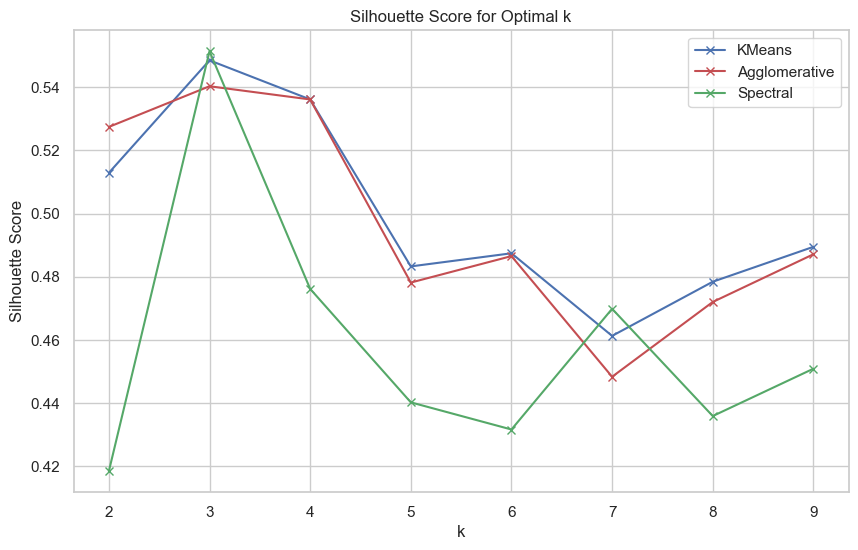

Optimal k for KMeans according to Silhouette Score: 3
Optimal k for Agglomerative Clustering according to Silhouette Score: 3
Optimal k for Spectral Clustering according to Silhouette Score: 3


In [56]:
def silhouette_scores(reduced_features):
    silhouette_scores_kmeans = []
    silhouette_scores_agg = []
    silhouette_scores_spec = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels_kmeans = kmeans.fit_predict(reduced_features)
        silhouette_scores_kmeans.append(silhouette_score(reduced_features, labels_kmeans))

        agg_clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
        labels_agg = agg_clustering.fit_predict(reduced_features)
        silhouette_scores_agg.append(silhouette_score(reduced_features, labels_agg))

        spec = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels_spec = spec.fit_predict(reduced_features)
        silhouette_scores_spec.append(silhouette_score(reduced_features, labels_spec))

    plt.figure(figsize=(10, 6))
    plt.plot(K, silhouette_scores_kmeans, 'bx-', label='KMeans')
    plt.plot(K, silhouette_scores_agg, 'rx-', label='Agglomerative')
    plt.plot(K, silhouette_scores_spec, 'gx-', label='Spectral')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.legend()
    plt.show()

    best_k_kmeans = K[np.argmax(silhouette_scores_kmeans)]
    best_k_agg = K[np.argmax(silhouette_scores_agg)]
    best_k_spec = K[np.argmax(silhouette_scores_spec)]
    print(f'Optimal k for KMeans according to Silhouette Score: {best_k_kmeans}')
    print(f'Optimal k for Agglomerative Clustering according to Silhouette Score: {best_k_agg}')
    print(f'Optimal k for Spectral Clustering according to Silhouette Score: {best_k_spec}')
    return best_k_kmeans, best_k_agg, best_k_spec

optimal_k_kmeans, optimal_k_agg, optimal_k_spec = silhouette_scores(reduced_features)

K-MEANS CLUSTERING

In [57]:
# KMeans kullanarak kümeleme
num_clusters = optimal_k_kmeans  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
chapterCorpus['KMeans Cluster'] = kmeans.fit_predict(reduced_features)

fig = px.scatter(chapterCorpus, x='Dimension 1', y='Dimension 2', color='KMeans Cluster', hover_name='Chapter Name',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 title='Finding Similar Episodes with K-Means Clustering',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()

AGGLOMERATIVE CLUSTERING

In [58]:
# Agglomerative Clustering kullanarak kümeleme
num_clusters = optimal_k_agg  
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
chapterCorpus['Agg Cluster'] = agg_clustering.fit_predict(reduced_features)

fig = px.scatter(chapterCorpus, x='Dimension 1', y='Dimension 2', color='Agg Cluster', hover_name='Chapter Name',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 title='Finding Similar Episodes with Agglomerative Clustering',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()

SPECTRAL CLUSTERING

In [59]:

spectral = SpectralClustering(n_clusters=optimal_k_spec, affinity='nearest_neighbors', random_state=42)
chapterCorpus['Spectral Cluster'] = spectral.fit_predict(reduced_features)

# Spectral Clustering 
fig = px.scatter(chapterCorpus, x='Dimension 1', y='Dimension 2', color='Spectral Cluster', hover_name='Chapter Name',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 title='Finding Similar Episodes with Spectral Clustering',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()

3 MODEL ARASINDA PERFORMANS DEĞERLENDİRME

                             KMeans Agglomerative    Spectral
Silhouette Score            0.54853      0.540326    0.551405
Dunn Index                 0.550505      0.553673    0.562259
Calinski-Harabasz Index  116.353819    108.854291  115.399292


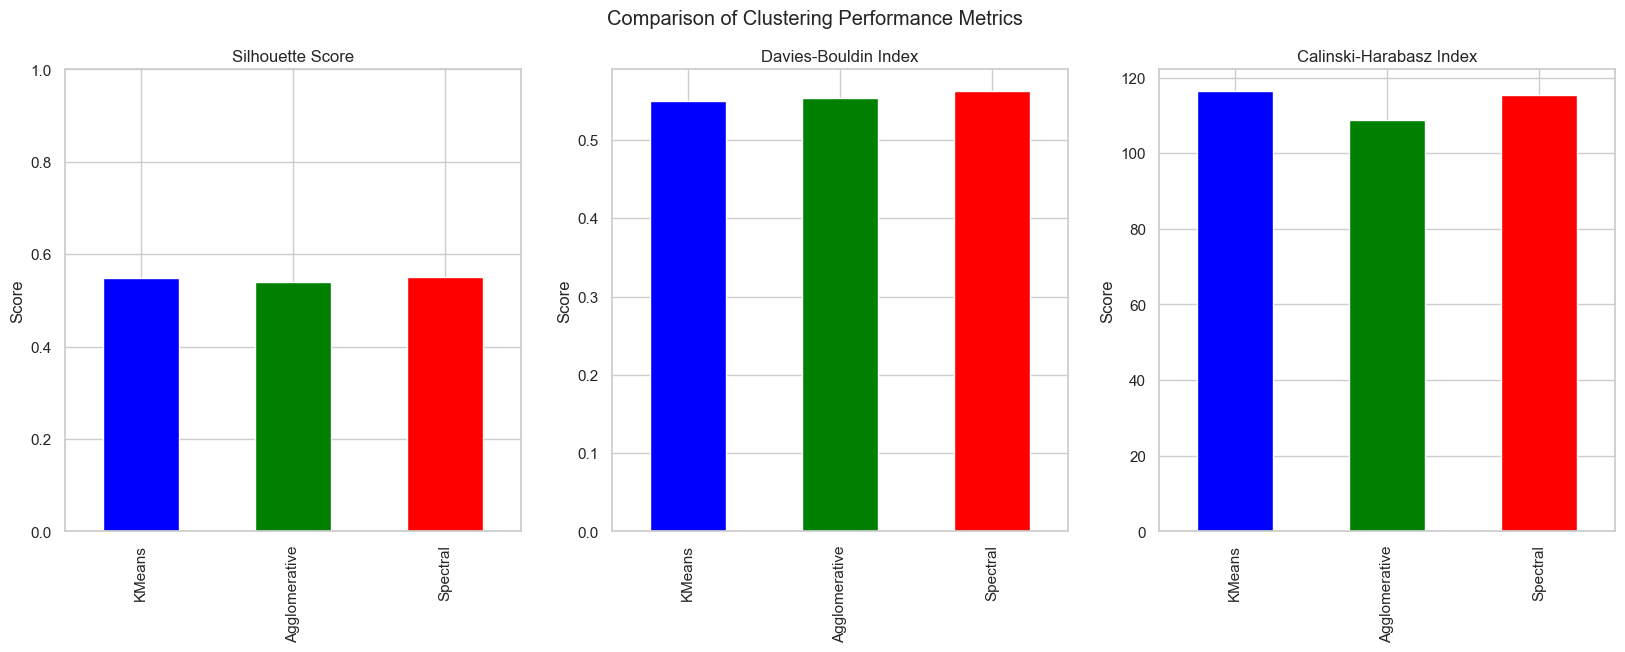

In [60]:
# Performans değerlendirme
metrics = {
    "Silhouette Score": silhouette_score,
    "Dunn Index": davies_bouldin_score,
    "Calinski-Harabasz Index": calinski_harabasz_score
}

results = pd.DataFrame(index=metrics.keys(), columns=['KMeans', 'Agglomerative', 'Spectral'])

for metric_name, metric_func in metrics.items():
    if metric_name == "Silhouette Score":
        results.loc[metric_name, 'KMeans'] = metric_func(reduced_features, chapterCorpus['KMeans Cluster'])
        results.loc[metric_name, 'Agglomerative'] = metric_func(reduced_features, chapterCorpus['Agg Cluster'])
        results.loc[metric_name, 'Spectral'] = metric_func(reduced_features, chapterCorpus['Spectral Cluster'])
    else:
        results.loc[metric_name, 'KMeans'] = metric_func(reduced_features, chapterCorpus['KMeans Cluster'])
        results.loc[metric_name, 'Agglomerative'] = metric_func(reduced_features, chapterCorpus['Agg Cluster'])
        results.loc[metric_name, 'Spectral'] = metric_func(reduced_features, chapterCorpus['Spectral Cluster'])

print(results)
# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Silhouette Score
results.loc["Silhouette Score"].plot(kind='bar', ax=axes[0], color=['blue', 'green', 'red'])
axes[0].set_title('Silhouette Score')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)  # Silhouette Score is typically between -1 and 1

# Dunn Index 
results.loc["Dunn Index"].plot(kind='bar', ax=axes[1], color=['blue', 'green', 'red'])
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_ylabel('Score')

# Calinski-Harabasz Index
results.loc["Calinski-Harabasz Index"].plot(kind='bar', ax=axes[2], color=['blue', 'green', 'red'])
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_ylabel('Score')

plt.suptitle('Comparison of Clustering Performance Metrics')
plt.show()


---------------------------------------------
---------------------------------CHARACTER CLUSTERING--------------------------------
-------------------------------------------------------------------------
------------------------------------

Corpus Oluşturma ve Özellik Seçme

In [61]:
# Önemli karakterler
important_characters = ['Aang', 'Katara', 'Zuko', 'Sokka', 'Toph', 'Iroh', 'Azula','Suki','Jet','Ozai']

# Veri hazırlığı
characterCorpus = pd.DataFrame({'Character': [], 'Full Text': []})
characters = []
characterTexts = []

# Her önemli karakterin metinleri
for character in important_characters:
    df = data[data['character'] == character]
    full_text = df['character_words'].dropna().astype(str).values  # NaN değerleri kaldır ve stringe çevir
    characters.append(character)
    characterTexts.append(" ".join(full_text).lower())

characterCorpus['Character'] = characters
characterCorpus['Full Text'] = characterTexts

# TF-IDF vektörizasyonu
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(characterCorpus['Full Text'])

# PCA 
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(X.toarray())

characterCorpus['Dimension 1'] = pca_features[:, 0]
characterCorpus['Dimension 2'] = pca_features[:, 1]

Cluster Sayısını Seçme

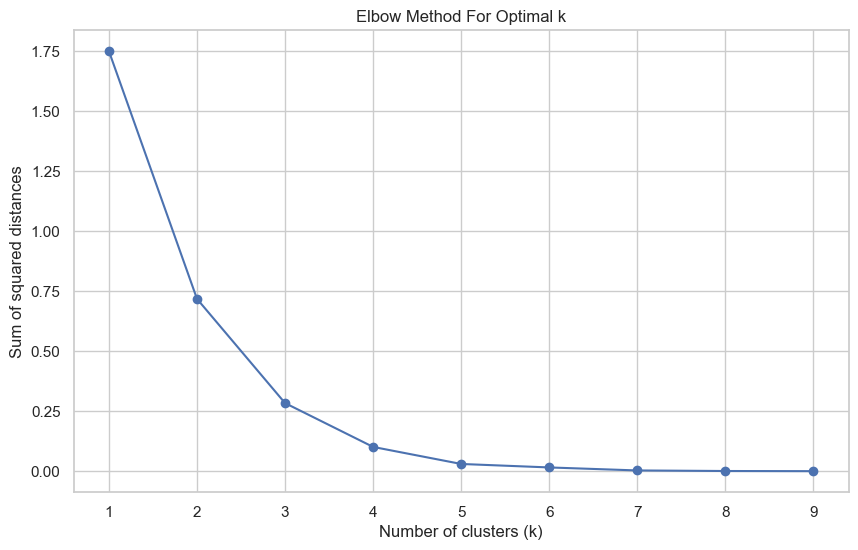

In [62]:
# Elbow Methodu ile optimal k değerini belirleme
sse = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    sse.append(kmeans.inertia_)

# Elbow Methodu grafiği
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

K-MEANS CLUSTERING

In [63]:
# KMeans kullanarak kümeleme
kmeans = KMeans(n_clusters=3, random_state=42) #elbow graphından seçildi
characterCorpus['KMeans Cluster'] = kmeans.fit_predict(pca_features)

fig = px.scatter(characterCorpus, x='Dimension 1', y='Dimension 2', color='KMeans Cluster', hover_name='Character',
                 title='Character Clustering with KMeans',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()


AGGLOMERATIVE CLUSTERING

In [64]:
# Agglomerative Clustering kullanarak kümeleme
agg_clustering = AgglomerativeClustering(n_clusters=3)
characterCorpus['Agg Cluster'] = agg_clustering.fit_predict(pca_features)

fig = px.scatter(characterCorpus, x='Dimension 1', y='Dimension 2', color='Agg Cluster', hover_name='Character',
                 title='Character Clustering with Agglomerative Clustering',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()

SPECTRAL CLUSTERING

In [65]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
characterCorpus['Spectral Cluster'] = spectral.fit_predict(pca_features)

fig = px.scatter(characterCorpus, x='Dimension 1', y='Dimension 2', color='Spectral Cluster', hover_name='Character',
                 title='Character Clustering with Spectral Clustering',
                 template='plotly_white')
fig.update_traces(marker=dict(size=12))
fig.show()

Adjusted Rand Index (ARI):
               ARI
Spectral -0.091954
KMeans    0.444444
Agg       0.444444

Normalized Mutual Information (NMI):
               NMI
Spectral  0.284953
KMeans    0.680963
Agg       0.680963


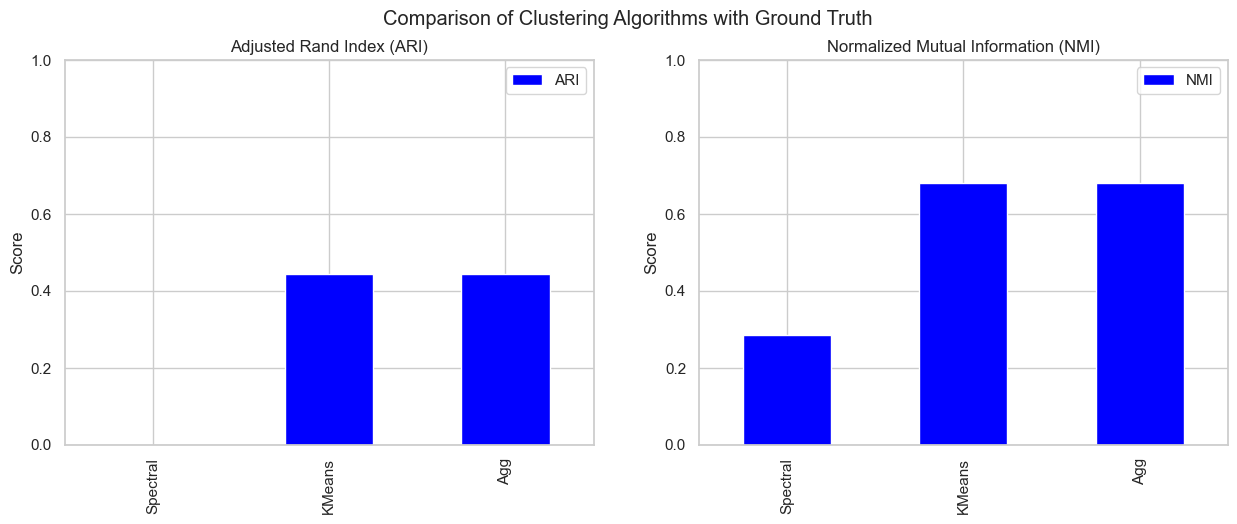

In [66]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Ground truth 
ground_truth = {
    'Ozai': 0,
    'Azula': 0,
    'Iroh': 1,
    'Zuko': 1,
    'Aang': 2,
    'Katara': 2,
    'Sokka': 2,
    'Toph': 2,
    'Suki': 3,
    'Jet': 3
}


characterCorpus['Ground Truth'] = characterCorpus['Character'].map(ground_truth)


ari_results = {}
nmi_results = {}

for cluster_method in ['Spectral', 'KMeans', 'Agg']:
    ari_results[cluster_method] = adjusted_rand_score(characterCorpus['Ground Truth'], characterCorpus[f'{cluster_method} Cluster'])
    nmi_results[cluster_method] = normalized_mutual_info_score(characterCorpus['Ground Truth'], characterCorpus[f'{cluster_method} Cluster'])

ari_df = pd.DataFrame.from_dict(ari_results, orient='index', columns=['ARI'])
nmi_df = pd.DataFrame.from_dict(nmi_results, orient='index', columns=['NMI'])

print("Adjusted Rand Index (ARI):")
print(ari_df)
print("\nNormalized Mutual Information (NMI):")
print(nmi_df)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ari_df.plot(kind='bar', ax=axes[0], color=['blue', 'green', 'red'])
axes[0].set_title('Adjusted Rand Index (ARI)')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)

nmi_df.plot(kind='bar', ax=axes[1], color=['blue', 'green', 'red'])
axes[1].set_title('Normalized Mutual Information (NMI)')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

plt.suptitle('Comparison of Clustering Algorithms with Ground Truth')
plt.show()


In [67]:
# En yüksek 15 IMDb puanına sahip bölümler
top_15_chapters = chapter_ratings.nlargest(15, 'imdb_rating')

# Bu bölümlerr hangi kümelerde 
top_15_clusters = chapterCorpus[chapterCorpus['Chapter Name'].isin(top_15_chapters['chapter'])]

cluster_counts = top_15_clusters['KMeans Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

fig = px.bar(cluster_counts, x='Cluster', y='Count',
             labels={'Cluster': 'Cluster', 'Count': 'Number of Chapters'},
             title='Top 10 IMDb Rated Chapters by Cluster',
             hover_data={'Cluster': True})


fig.show()
